In [1]:
!pip install hvplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.2 MB 34.6 MB/s 


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import hvplot.pandas
from scipy import stats

%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

Output hidden; open in https://colab.research.google.com to view.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = pd.read_csv("/content/drive/MyDrive/Enseignement/ISET/Articles/Article 3/Code/stress3.csv")
data.head()

,spo2,bpm,sweat,status
0,91,96,308,0
1,95,99,360,1
2,93,102,245,2
3,95,89,215,2
4,89,99,324,2


In [5]:
categorical_val = []
continous_val = []
for column in data.columns:
    if len(data[column].unique()) <= 10:
        categorical_val.append(column)
    else:
        continous_val.append(column)

In [6]:
categorical_val

['status']

# 🔄 Data Processing

After exploring the dataset, I observed that I need to convert some categorical variables into dummy variables and scale all the values before training the Machine Learning models.
First, I'll use the `get_dummies` method to create dummy columns for categorical variables.

In [7]:
#categorical_val.remove('target')
#dataset = pd.get_dummies(data, columns = categorical_val)

In [8]:
dataset=data
dataset.head()

,spo2,bpm,sweat,status
0,91,96,308,0
1,95,99,360,1
2,93,102,245,2
3,95,89,215,2
4,89,99,324,2


In [9]:
from sklearn.preprocessing import StandardScaler

s_sc = StandardScaler()
col_to_scale = ['spo2', 'bpm', 'sweat']
dataset[col_to_scale] = s_sc.fit_transform(dataset[col_to_scale])

In [10]:
dataset.head()

,spo2,bpm,sweat,status
0,-0.073197,0.088803,0.336946,0
1,0.600218,0.212242,1.103703,1
2,0.263510,0.335681,-0.592010,2
3,0.600218,-0.199221,-1.034370,2
4,-0.409905,0.212242,0.572871,2


# 🤖 Models Building

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

def matrice(preds, y_test, title):
    cf_matrix = confusion_matrix(y_test, preds)
    print(cf_matrix)

    ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
    ax.set_title(title);
    ax.set_xlabel('\nPredicted class')
    ax.set_ylabel('Actual class');
    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['No\nStress','Low\nStress','High\nStress'])
    ax.yaxis.set_ticklabels(['No\nStress','Low\nStress','High\nStress'])
    ## Display the visualization of the Confusion Matrix.
    plt.show()

In [12]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score, matthews_corrcoef
from sklearn.metrics import classification_report

def print_score(preds, y_test):
    #clf_report = pd.DataFrame(classification_report(y_test, preds, output_dict=True))
    print("Test Result:\n================================================")        
    print(f"Accuracy Score: {accuracy_score(y_test, preds) * 100:.2f}%")
    print(f"F1 Score: {f1_score(y_test, preds, average='weighted') * 100:.2f}%")
    print(f"MCC Score: {matthews_corrcoef(y_test, preds) * 100:.2f}%")
    print(f"Precision: {precision_score(y_test, preds, average='weighted') * 100:.2f}%")
    print(f"Recall: {recall_score(y_test, preds, average='weighted') * 100:.2f}%")
    #print("\nDetails:\n================================================")    
    #target_names = ['No Stress','Low Stress','High Stress']
    #print(classification_report(y_test, preds, target_names=target_names, digits=4))

In [13]:
from sklearn.model_selection import train_test_split

X = dataset.drop('status', axis=1)
y = dataset.status

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Now we've got our data split into training and test sets, it's time to build a machine learning model.

We'll train it (find the patterns) on the training set.

And we'll test it (use the patterns) on the test set.

We're going to try 3 different machine learning models:
> 1. Logistic Regression 
> 2. K-Nearest Neighbours Classifier
> 3. Support Vector machine
> 4. Decision Tree Classifier
> 5. Random Forest Classifier

## 1. Logistic Regression Hyperparameter Tuning

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

params = {"C": np.logspace(-4, 4, 20),
          "solver": ["liblinear"]}

lr_clf = LogisticRegression()

lr_cv = GridSearchCV(lr_clf, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=3)
lr_cv.fit(X_train, y_train)
best_params = lr_cv.best_params_
print(f"Best parameters: {best_params}")
lr_clf = LogisticRegression(**best_params)

lr_clf.fit(X_train, y_train)
lr_preds = lr_clf.predict(X_test)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'C': 0.23357214690901212, 'solver': 'liblinear'}


In [15]:
print_score(lr_preds, y_test)

Test Result:
Accuracy Score: 68.33%
F1 Score: 67.32%
MCC Score: 51.96%
Precision: 68.36%
Recall: 68.33%


[[65  7 16]
 [26 34 19]
 [12  9 93]]


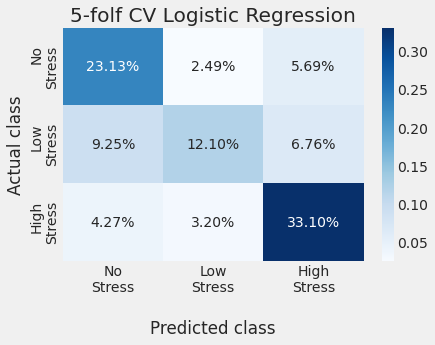

In [16]:
matrice(lr_preds, y_test,'5-folf CV Logistic Regression')

## 2. K-nearest neighbors Hyperparameter Tuning

In [17]:
from sklearn.neighbors import KNeighborsClassifier
train_score = []
test_score = []
neighbors = range(2, 18)

for k in neighbors:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    train_score.append(accuracy_score(y_train, model.predict(X_train)))
    test_score.append(accuracy_score(y_test, model.predict(X_test)))

In [18]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 20}

plt.rc('font', **font)
plt.rc('ytick', labelsize=20) 

Maximum KNN score on the test data: 83.07%


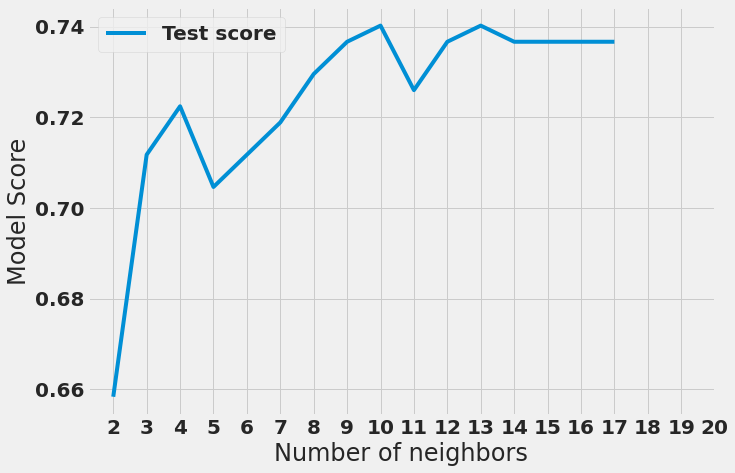

In [23]:
plt.figure(figsize=(10, 7))

#plt.plot(neighbors, train_score, label="Train score")
plt.plot(neighbors, test_score, label="Test score")
plt.xticks(np.arange(2, 21, 1))
plt.xlabel("Number of neighbors")
plt.ylabel("Model Score")
plt.legend()

print(f"Maximum KNN score on the test data: {max(train_score)*100:.2f}%")

In [20]:
knn_clf = KNeighborsClassifier(n_neighbors=3)
knn_clf.fit(X_train, y_train)
knn_preds = knn_clf.predict(X_test)

In [21]:
print_score(knn_preds, y_test)

Test Result:
Accuracy Score: 71.17%
F1 Score: 71.18%
MCC Score: 57.11%
Precision: 72.90%
Recall: 71.17%


## 3. Support Vector Machine Hyperparameter Tuning

In [ ]:
from sklearn.svm import SVC
svm_clf = SVC(kernel='rbf', gamma=0.1, C=1.0, probability=True)
svm_clf2 = SVC(kernel='rbf', gamma=1, C=2.0, probability=True)

params = {"C":(0.1, 0.5, 1, 2, 5, 10, 20), 
          "gamma":(0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1), 
          "kernel":('linear', 'poly', 'rbf')}

svm_cv = GridSearchCV(svm_clf2, params, n_jobs=-1, cv=3, verbose=1, scoring="accuracy")
svm_cv.fit(X_train, y_train)
best_params = svm_cv.best_params_
print(f"Best params: {best_params}")

svm_clf = SVC(**best_params)
#svm_clf.fit(X_train, y_train)
#svm_preds = svm_clf.predict(X_test)
svm_clf2.fit(X_train, y_train)
svm_preds = svm_clf2.predict(X_test)


Fitting 3 folds for each of 147 candidates, totalling 441 fits
Best params: {'C': 2, 'gamma': 1, 'kernel': 'rbf'}


In [ ]:
print_score(svm_preds, y_test)

Test Result:
Accuracy Score: 76.51%
F1 Score: 76.40%
MCC Score: 64.95%
Precision: 78.90%
Recall: 76.51%


## 4. Decision Tree Classifier Hyperparameter Tuning

In [ ]:
from sklearn.tree import DecisionTreeClassifier
params = {"criterion":("gini", "entropy"), 
          "splitter":("best", "random"), 
          "max_depth":(list(range(1, 20))), 
          "min_samples_split":[2, 3, 4], 
          "min_samples_leaf":list(range(1, 20))
          }

tree_clf = DecisionTreeClassifier(random_state=42)
tree_cv = GridSearchCV(tree_clf, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=3)
tree_cv.fit(X_train, y_train)
best_params = tree_cv.best_params_
print(f'Best_params: {best_params}')

tree_clf = DecisionTreeClassifier(**best_params)
tree_clf.fit(X_train, y_train)
tree_preds = tree_clf.predict(X_test)


Fitting 3 folds for each of 4332 candidates, totalling 12996 fits
Best_params: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 19, 'min_samples_split': 2, 'splitter': 'best'}


In [ ]:
print_score(tree_preds, y_test)

Test Result:
Accuracy Score: 73.67%
F1 Score: 73.68%
MCC Score: 60.42%
Precision: 75.59%
Recall: 73.67%


## 5. Random Forest Classifier Hyperparameter Tuning

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [500, 900, 1100, 1500]
max_features = ['auto', 'sqrt']
max_depth = [2, 3, 5, 10, 15, None]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

params_grid = {
    'n_estimators': n_estimators, 
    'max_features': max_features,
    'max_depth': max_depth, 
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf
              }

rf_clf = RandomForestClassifier(random_state=42)
rf_cv = GridSearchCV(rf_clf, params_grid, scoring="accuracy", cv=3, verbose=1, n_jobs=-1)
rf_cv.fit(X_train, y_train)
best_params = rf_cv.best_params_
print(f"Best parameters: {best_params}")

rf_clf = RandomForestClassifier(**best_params)
rf_clf.fit(X_train, y_train)
rf_preds = rf_clf.predict(X_test)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters: {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 900}


In [ ]:
print_score(rf_preds, y_test)

Test Result:
Accuracy Score: 75.09%
F1 Score: 74.73%
MCC Score: 62.91%
Precision: 77.83%
Recall: 75.09%


[[74  4 10]
 [20 43 16]
 [20  0 94]]


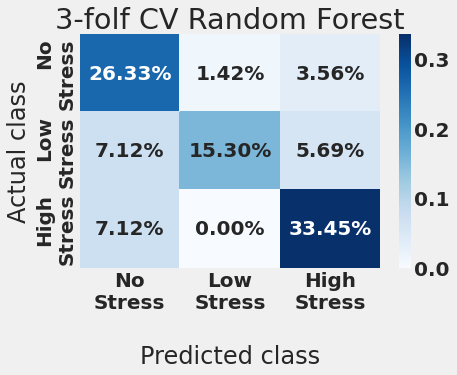

In [ ]:
matrice(rf_preds, y_test,'3-folf CV Random Forest')

## Simple Averaging Approach

In [ ]:
averaged_preds = (lr_clf.predict(X_test) + knn_clf.predict(X_test) + svm_clf2.predict(X_test) + tree_clf.predict(X_test) + rf_clf.predict(X_test))//5
print_score(averaged_preds, y_test)

Test Result:
Accuracy Score: 69.40%
F1 Score: 69.54%
MCC Score: 55.18%
Precision: 72.15%
Recall: 69.40%


## Voting\Stacking Classification Example

In [ ]:
from sklearn.ensemble import VotingClassifier
hard_voting_clf = VotingClassifier(estimators=[('LR', lr_clf), ('KNN', knn_clf), ('SVM', svm_clf2), ('DT', tree_clf), ('RF', rf_clf)], voting='hard')
hard_voting_clf.fit(X_train, y_train)
hard_preds = hard_voting_clf.predict(X_test)

In [ ]:
print_score(hard_preds, y_test)

Test Result:
Accuracy Score: 75.44%
F1 Score: 75.44%
MCC Score: 63.75%
Precision: 78.82%
Recall: 75.44%


In [ ]:
from sklearn.ensemble import VotingClassifier
soft_voting_clf = VotingClassifier(estimators=[('LR', lr_clf), ('KNN', knn_clf), ('SVM', svm_clf2), ('DT', tree_clf), ('RF', rf_clf)], voting='soft', weights=[1,1,1,1,2])
soft_voting_clf.fit(X_train, y_train)
soft_preds = soft_voting_clf.predict(X_test)

In [ ]:
print_score(soft_preds, y_test)

Test Result:
Accuracy Score: 77.22%
F1 Score: 77.21%
MCC Score: 65.96%
Precision: 79.33%
Recall: 77.22%


[[73  4 11]
 [20 49 10]
 [18  1 95]]


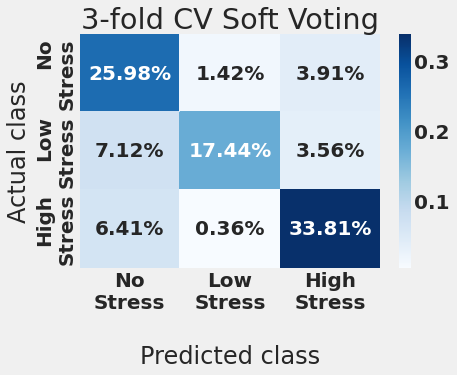

In [ ]:
matrice(soft_preds, y_test,'3-fold CV Soft Voting')

## Enregistrement des modèles

In [ ]:
import pickle
path= "/content/drive/MyDrive/Enseignement/ISET/Articles/Article 3/Code/Models/" 
LR_CV_path = path+"LR_CV3_model.pickle" 
KNN_CV_path = path+"KNN_CV3_model.pickle" 
SVM_CV_path = path+"SVM_CV3_model.pickle" 
TREE_CV_path = path+"TREE_CV3_model.pickle" 
RF_CV_path = path+"RF_CV3_model.pickle" 
HARD_VOTING_CV_path = path+"HARD_VOTING_CV3_model.pickle" 
SOFT_VOTING_CV_path = path+"SOFT_VOTING_CV3_model.pickle" 

# save models
pickle.dump(lr_clf, open(LR_CV_path, "wb"))
pickle.dump(knn_clf, open(KNN_CV_path, "wb"))
pickle.dump(svm_clf2, open(SVM_CV_path, "wb"))
pickle.dump(tree_clf, open(TREE_CV_path, "wb"))
pickle.dump(rf_clf, open(RF_CV_path, "wb"))
pickle.dump(hard_voting_clf, open(HARD_VOTING_CV_path, "wb"))
pickle.dump(soft_voting_clf, open(SOFT_VOTING_CV_path, "wb"))